###  Using the class spectral analysis

Tutorial on how to use the spectral analysis class to compute power spectrum, spectogram, and the pairwise coherence.

In [1]:
%matplotlib inline
import time
import numpy                 as     np
import matplotlib.pyplot     as     plt
from   GDa.spectral_analysis import spectral_analysis
from   GDa.session           import session
from   GDa.misc              import smooth_spectra

Let's start by loading a session data:

In [2]:
# Session data
session_data = np.load('raw_lfp/lucy_session01_150128.npy', allow_pickle=True).item()
# LFP data
LFP          = session_data['data']
# Index of all pair of channels
pairs        = session_data['info']['pairs']
# Sample frequency
fsample      = int(session_data['info']['fsample'])
# Directory were to save the coherence data
dir_out      = session_data['path']['dir_out']

To instantiate the __spectral_analysis__ class:

In [3]:
spec = spectral_analysis()

We can plot a random LFP signal:

In [4]:
lfp   = LFP[0,10,:]
# Time axis, using from -0.65 to 3.00 s because this is the event dt we used when we saved the data
tarr = np.linspace(-0.65, 3.00, lfp.shape[-1]) 

Text(0, 0.5, 'mV')

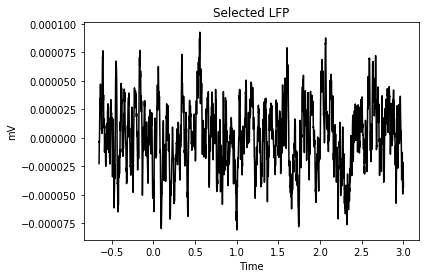

In [5]:
# Plotting the signal
plt.plot(tarr, lfp, 'k')
plt.title('Selected LFP')
plt.xlabel('Time')
plt.ylabel('mV')

We can bandpass filter the data with the function __filter__ in __spectral_analysis__, let's filter it on the alpha band (8-15 Hz):

In [6]:
LFP_filtered = spec.filter(data = LFP, fs = fsample, f_low = 8, f_high = 12, n_jobs = -1)

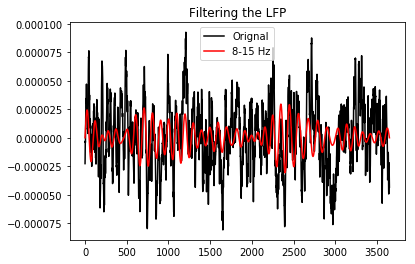

In [7]:
plt.plot(lfp, 'k')
plt.plot(LFP_filtered[0,10,:], 'r')
plt.title('Filtering the LFP')
plt.legend(['Orignal', '8-15 Hz'])

We can compute the wavelets of the signal using the function __wavelet_transform__, which allows to use morlet or multitaper transforms.

In [8]:
# Defining frequencies
freqs = np.arange(4,60,2)

# Morlet
W_ml = spec.wavelet_transform(data = LFP,  
                              fs = fsample, freqs = freqs, n_cycles = 5,
                              time_bandwidth = None, delta = 15, method = 'morlet', n_jobs = -1)

# Multitaper
#W_mt = spec.wavelet_transform(data = LFP,  
#                              fs = fsample, freqs = freqs, n_cycles = freqs/2.0,
#                              time_bandwidth = 8.0, delta = 15, method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   12.8s remaining:   18.5s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   13.7s remaining:    8.7s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   14.8s remaining:    3.3s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   17.5s finished


The auto spectra can be computed as tem elementwise product of $W$ and its conjugate:

In [9]:
Sauto_ml = W_ml * np.conj(W_ml)
#Sauto_mt = W_mt * np.conj(W_mt)

Next, we can visualize the result for __trial=0__, and __channel=10__:

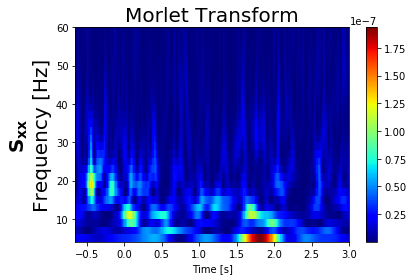

In [10]:
#plt.figure(figsize=(10,4))
# Sxx
#plt.subplot(1,2,1)
plt.imshow(Sauto_ml[0,10,:,:].real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,4,60]);plt.colorbar()
plt.title('Morlet Transform', fontsize=20)
plt.ylabel(r"$\bf{S_{xx}}$" + "\n" + "Frequency [Hz]", fontsize=20)
plt.xlabel('Time [s]')
#plt.subplot(1,2,2)
#plt.imshow(Sauto_mt[0,10,:,:].real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,3,40]);plt.colorbar()
#plt.title('Multitaper Transform', fontsize=20)
#plt.xlabel('Time [s]')
plt.tight_layout()

Finally we can compute the (single trial) time-frequency coherence between two signals by using the function __wavelet_coherence__, for each trial and pair a file will be saved in __dir_out__ with the coherence data.

An array with the pairs of channels (pairs = $[[0,1], [0,2], \dots, [n,n]]$) should be passed to the function.

If $n_{\rm jobs}>1$, it will parallelize on pairs of channels, to test let's compute it passing only one trial of the data, and measure the execution time:

In [11]:
start = time.time()

spec.wavelet_coherence(data = LFP[0,:,:][np.newaxis,:,:], pairs = pairs, fs = fsample, freqs = freqs, 
                       n_cycles = 5, time_bandwidth = None, delta = 15, method = 'morlet', 
                       win_time = 34, win_freq = 1, dir_out = dir_out, n_jobs = -1)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    0.3s finished


Elapsed time to load super-tensor: 9.653714418411255 sec.


We can load a saved file with the coherence in order to plot:

In [12]:
coh = np.load('Results/lucy/150128/session01/trial_0_ch1_10_ch2_30.npy', allow_pickle=True).item()['coherence']

Text(0.5, 0, 'Time [s]')

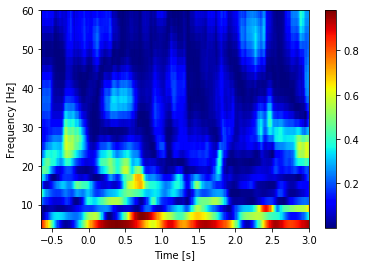

In [13]:
plt.imshow(coh.real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3,4,60]); plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

Let's compute the coherences for different number of trials to estimate the execution time for a entire session.

In [15]:
trial_size = np.arange(1,26,5)
t          = []

for ts in trial_size:
    print('Trial size = ' + str(ts))
    start = time.time()
    spec.wavelet_coherence(data = LFP[:ts,:,:], pairs = pairs, fs = fsample, freqs = freqs, 
                           n_cycles = 5, time_bandwidth = None, delta = 15, method = 'morlet', 
                           win_time = 34, win_freq = 1, dir_out = dir_out, n_jobs = -1)

    end = time.time()
    t.append((end - start))

Trial size = 1


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    3.2s remaining:    4.6s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    3.2s remaining:    2.0s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    3.3s remaining:    0.7s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    3.4s finished


Trial size = 6


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    3.4s remaining:    5.0s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    3.5s remaining:    2.2s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    3.5s remaining:    0.8s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    3.5s finished


Trial size = 11


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    3.2s remaining:    4.6s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    3.3s remaining:    2.1s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    3.3s remaining:    0.7s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    3.4s finished


Trial size = 16


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    3.4s remaining:    4.9s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    3.5s remaining:    2.2s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    3.5s remaining:    0.8s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    3.6s finished


Trial size = 21


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    3.4s remaining:    4.9s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    3.4s remaining:    2.2s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    3.5s remaining:    0.8s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    3.6s finished


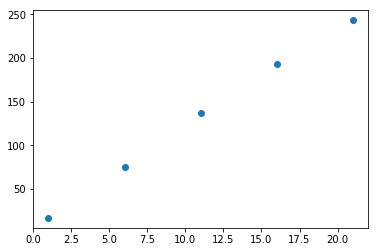

In [18]:
p, _ = np.polyfit(trial_size, t, 1)
plt.plot(trial_size, t, 'o')

In [25]:
p*540/60

102.72062026977538

In [26]:
W_ml.shape

(540, 49, 28, 244)